In [1]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# general utility
import networkx as nx
import numpy as np
import re

# node embeddings packages
from node2vec import Node2Vec
import node2vec.edges as ee

## Simulated Data
Below we use the barabasi albert function of Networkx to generate a graph with a structure similar to PPI datasets. We create a very small graph so it is possible to view the consequences of using Node2vec to embed edges of this graph into latent space.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


The data contains 20 nodes, and 36 edges


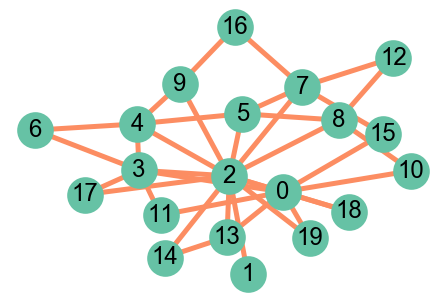

In [3]:
# some theme compatability issues
pal = sns.color_palette('Set2')
cmap = sns.color_palette('Set2', as_cmap=True)
c1 = cmap(0)
c2 = cmap(1)
sns.set_theme(palette=pal)
graph_vis_options = {
    "font_size": 24,
    "node_size": 1000,
    "linewidths": 5,
    "arrows": True,
    "width": 5,
    "node_color": c1,
    "edge_color": c2
}


def simulate_data(n, m):
    """
    returns networkx graph with n nodes
    """
    graph = nx.barabasi_albert_graph(n, m)
    return graph


def vis_graph(graph, set_labels=True, options=graph_vis_options):
    """
    visualise graph through networkx draw
    """
    position = nx.spring_layout(graph)
    labels = {node: node for node in graph.nodes()}
    nodes = nx.draw(graph, position, labels=labels, **options)
    return nodes

N = 20
data = simulate_data(N, 2)
M = len(data.edges)
vis_graph(data)
print(f'The data contains {N} nodes, and {M} edges')

## Training the model
The node2vec model is trained, this gives us the node embeddings to determine similarity between nodes, and more importantly, the edge embeddings. 

In [4]:
def train_node_embeddings(graph, embedding_dim, fname_model=None):
    node2vec = Node2Vec(graph, dimensions=embedding_dim,
                        walk_length=100, num_walks=50, workers=4)

    # Embed nodes
    emb_model = node2vec.fit(window=10, min_count=1, batch_words=4)
    # Save model for later use
    if fname_model is not None:
        emb_model.save(fname_model)
    return emb_model


def train_edge_embeddings(graph, emb_model, emb_name='l2', fname_edge_embs=None):
    if emb_name == 'average':
        edges_embs = ee.AverageEmbedder(keyed_vectors=emb_model.wv)
    elif emb_name == 'hadamard':
        edges_embs = ee.HadamardEmbedder(keyed_vectors=emb_model.wv)
    elif emb_name == 'l1':
        edges_embs = ee.WeightedL1Embedder(keyed_vectors=emb_model.wv)
    else:
        edges_embs = ee.WeightedL2Embedder(keyed_vectors=emb_model.wv)

    # Save embeddings for later use
    if fname_edge_embs is not None:
        edges_embs.as_keyed_vectors().save_word2vec_format(fname_edge_embs)

    return edges_embs


def get_edge_embeddings(data, embed_dim, emb_name='l2'):
    """
    input data, return node features, edge features, 
    """
    emb_model = train_node_embeddings(data, embed_dim)
    edge_embeddings = train_edge_embeddings(data, emb_model, emb_name=emb_name)
    ee_kv = edge_embeddings.as_keyed_vectors()

    return emb_model.wv.vectors, ee_kv.vectors, ee_kv


embed_dim = 2
nodes, edges, ee_kv = get_edge_embeddings(data, embed_dim)
    
print(f'The network nodes data is now embedded in {embed_dim} dimensions')

Generating edge features: 100%|██████████| 210/210.0 [00:00<00:00, 121456.68it/s]

The network nodes data is now embedded in 2 dimensions


## Edge Embeddings
As we can see in the visualisations below, embeddings are defined for all possible edges, not just edges that exist in the graph. However, directionality is discarded after embedding. Due to the nature of the implemented edge embeddings, an edge from node 1 to node 2 will output the same edge embedding as an edge from node 2 to node 1. For example, the Hadamard embedding will multiply the node embeddings of node 1 and node 2 together. More info at this link: https://github.com/eliorc/node2vec/issues/36

Nodes


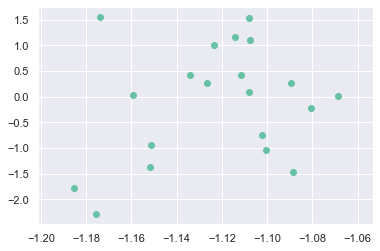

Edges


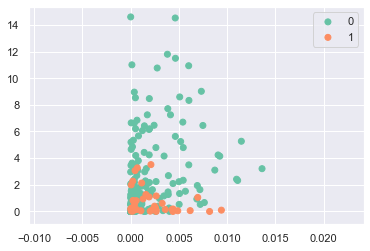

In [5]:
def data_to_2d(data):
    """
    Project input data to 2D space with tSNE
    """
    if data.shape[1] == 2:
        data2d = data
    else:
        tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')
        data2d = tsne.fit_transform(data)
    return data2d


def vis_embeddings(data, options={}):
    """
    Project embeddings in 2D space and return visualisation
    """
    # project to 2d space
    embeddings2d = data_to_2d(data)

    # plot
    fig = plt.figure()
    plt.scatter(embeddings2d[:, 0], embeddings2d[:, 1])
    return fig


def vis_labeled_embeddings(data, labels, color_list, options={}):
    """
    Project embeddings in 2D space and return visualisation with a legend

    Edge embeddings exist for all possible edges,
    class 1 exists in the data and class 0 does not
    """
    embeddings2d = data_to_2d(data)

    fig = plt.figure()
    # for each unique label, add to datapoint
    for label in np.unique(labels):
        label_indices = np.where(label == labels)

        plt.scatter(embeddings2d[label_indices, 0],
                    embeddings2d[label_indices, 1],
                    c=color_list[label_indices], label=label)
    plt.legend()
    return fig


def construct_embedding_labels(graph, edge_embedding_kv):
    edge_list = list(graph.edges)
    labels = []
    for k, _ in edge_embedding_kv.vocab.items():
        sk = re.sub('[^a-zA-Z\d\s:]', '', k).split(' ')
        sk, skr = (int(sk[0]), int(sk[1])), (int(sk[1]), int(sk[0]))
        if (sk in edge_list) or (skr in edge_list):
            labels.append(1)
        else:
            labels.append(0)
    return np.array(labels)


def vis_edge_embeddings(data, edges, edge_labels):
    """
    @data: networkx graph
    @ee_kv: edge embeddings as keyed vector, trained on data input

    returns figure of 2d projected edge embeddings
    """
    label_colors = cmap(edge_labels)
    fig = vis_labeled_embeddings(edges, edge_labels, label_colors)
    return fig


print('Nodes')
fig2dnodes = vis_embeddings(nodes)
plt.show()

print('Edges')
edge_labels = construct_embedding_labels(data, ee_kv)
embeddings2dedges = vis_edge_embeddings(data, ee_kv.vectors, edge_labels)
plt.show()

## Classifier
Classify points

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


def classify(X, y, cl=-1):
    # normalize data
    X = StandardScaler().fit_transform(X)
    clf = classifiers[cl]
    clf.fit(X, y)

    return clf

clf = classify(edges, edge_labels)

clf.score(edges, edge_labels)

0.8285714285714286